In [4]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from translate import Translator

import os 
import tweepy as tw 
import datetime
import configparser as cp

import requests
import urllib.parse

# keys to extract tweets

In [2]:
config = cp.ConfigParser()
config.read('twitter_values.ini')

cons_key = config['twitter.com']['consumer_key']
cons_secret_key = config['twitter.com']['consumer_secret_key']
access_token = config['twitter.com']['access_token']
access_token_secret = config['twitter.com']['access_token_secret']


# collecting tweets of particular country

In [3]:
'''extacts tweets using twitter api and converts the text to english if not and return the dataframe'''



def extracting_tweets_from_tweeter(cons_key, cons_secret_key, access_token, access_token_secret, hashtags = 'covid', date_since, date_until):
    
    auth = tw.OAuthHandler(cons_key, cons_secret_key)
    auth.set_access_token(access_token, access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)

    search_words = hashtags
    new_search = search_words + "-filter:retweets" 
    
    tweets = tw.Cursor(api.search, q = new_search, since = date_since, until = date_until)
    user_locs = [[tweet.text, tweet.user.location] for tweet in tweets]
    tweet_text = pd.DataFrame(data = user_locs, columns=['text', 'location'])

''' extracting only tweets from "India" '''

    tweet_text = tweet_text[tweet_text['place_full_name'].notna()]
    tweet_text['place_full_name'] = tweet_text['place_full_name'].map(lambda x: x.lower())
    tweet_text.reset_index(drop = True)

    tweet_text = tweet_text[tweet_text['place_full_name'].str.contains('india')]
      
''' converting the non english tweet to english '''
        
    translator = Translator(to_lang = "english")
    text = []
    for tweet in tweet_text['text']:
        if detect(tweet) != 'en':
            text.append(translator.translate(tweet))
        else:
            text.append(tweet)
    tweet_text['converted_text'] = text
    
    return tweet_text
    

In [5]:
# date_until = datetime.date.today()
# data = extracting_tweets_from_tweeter(cons_key, cons_secret_key, access_token, access_token_secret, date_until)

In [59]:
# date_until = datetime.date.today()  # aaj ki date

# date_since = date_until - datetime.timedelta(days = 8)

# # print(date_until, date_since, '\n')
# for i in range(1,8):
#     date_since = date_since + datetime.timedelta(days = 1)
#     date_until = date_since + datetime.timedelta(days = 1)
# #     print(date_since, date_until)



2020-08-26 2020-08-18 

2020-08-19 2020-08-20
2020-08-20 2020-08-21
2020-08-21 2020-08-22
2020-08-22 2020-08-23
2020-08-23 2020-08-24
2020-08-24 2020-08-25
2020-08-25 2020-08-26


# Getting the longitude and latitude of the given location

In [ ]:
def getting_long_lat(data):

    lat = []; long = []

    def getting_lat_long(address):
        url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address)+'?format=json'
        response = requests.get(url).json()
        return response

    for i in data.location:
        res = getting_lat_long(i)
        try:
            lat.append(res[0]['lat'])
            long.append(res[0]['lon'])
        except:
            lat.append(np.nan)
            long.append(np.nan)

    data['lattitude'] = lat
    data['longitude'] = long
    
    return data


# Getting the states of the given tweets

In [18]:
def getting_state(data):
    
'''to add a column of state in the data set '''

    import reverse_geocoder as rg
    import pprint

    state = []
    for i in range(data.shape[0]):
        result = rg.search([data['latitude'][i], data['longitude'][i]])
        state.append(list(result)[0]['admin1'])
    data['state'] = state

return data

,text,latitude,longitude,state
0,"chandigarh,india",12.979120,77.591300,Karnataka
1,"mumbai,india",25.335649,83.007629,Uttar Pradesh
2,"thane,india",27.130334,80.859666,Uttar Pradesh


# Extracting the data of a particular state i.e. state entered by the user

In [102]:
def extract_state(data):
    '''extracting the data of particular state'''

    print('the option of states are : ')
    print(data['state'].unique())
    
    while(True):
        loc = input('enter the state for which you want to calculate : ')
        data = data[data['state'] == loc]
        if data.shape[0] != 0:
            break
        else:
            print('enter a valid value and try again.....')
        
    return data
  

# Getting Sentiment of the tweets

In [60]:
# assigning the sentiment of the tweet 

def getting_sentiment(data):
    tweets = data['text']
    sid = SentimentIntensityAnalyzer()
    data['scores'] = [sid.polarity_scores(tweet) for tweet in tweets]
    
    # for storing the sentiment of the tweet

    senti = []
    for score in data['scores']:
    #     print(score)
        if score['pos'] > score['neg']:
            senti.append(1)
        elif score['pos'] < score['neg']:
            senti.append(0)
        else:
            senti.append(np.nan)

    data['sentiment'] = senti

    # droping the text neural in nature
    data.dropna(axis = 0, inplace = True)

    return data

# Assigning of all functions

In [ ]:

date_until = datetime.date.today()  # getting current date 
date_since = date_until - datetime.timedelta(days = 8) # getting date of 8 days back

output = []
date_until = datetime.date.today()

for i in range(1,8):
    
    # increamenting the date after each iteration 
    date_since = date_since + datetime.timedelta(days = 1)
    date_until = date_since + datetime.timedelta(days = 1)
    
    # extracting the tweets from tweeter of the particular day 
    data = extracting_tweets_from_tweeter(cons_key, cons_secret_key, access_token, access_token_secret, 
                                          date_since, date_until)
    
    # getting latitude and longitude values of the data collected
    data = getting_long_lat(data) 
    
    # getting the state on the basis of latitude and longitude
    data = getting_state(data)
    
    # extracting the tweets of the particular state to minimize the load 
    data = extract_state(data)
    
    # getting the sentiments of the tweets
    data = getting_sentiment(data)
    
    # getting the values of number of tweets negative or positive
    values = data['sentiment'].value_counts()
    neg = value[0] # number of negative tweets
    pos = value[1] # number of positive tweets
    val = [neg, pos]
    output.append() # appeding the value in the list 
out = pd.DataFrame(output, columns = ['number of negative tweets', 'number of positive tweets'])
data = data.join(out)  # joining the dataframe into the dataset 
x = [1, 2, 3, 4, 5, 6, 7] 
data['day_number'] = x

In [76]:
# x = [1, 2, 3, 4, 5, 6, 7]
# y_neg = [12, 23, 34, 45, 5, 89, 6]
# y_pos = [32, 4, 67, 89, 23, 12, 34]

# data = pd.DataFrame([x, y_neg, y_pos], index=['day', 'number of negative tweets', 'number of positive tweets']).T

# data

,day,number of negative tweets,number of positive tweets
0,1,12,32
1,2,23,4
2,3,34,67
3,4,45,89
4,5,5,23
5,6,89,12
6,7,6,34


Text(0, 0.5, 'Number of Cases')

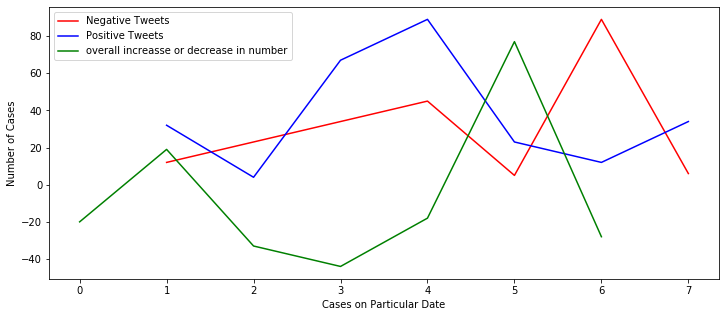

In [88]:
# ploting the number of negative and positive tweets graphically

plt.figure(figsize=(12, 5))
plt.plot(data['day'], data['number of negative tweets'], 'r')
plt.plot(data['day'], data['number of positive tweets'], 'b')
plt.plot(data['number of negative tweets'] - data['number of positive tweets'], 'g')
plt.legend(['Negative Tweets', 'Positive Tweets', 'overall increasse or decrease in number'])
plt.xlabel('Cases on Particular Date')
plt.ylabel('Number of Cases')